Problem Statement: 
- Given historical TTC subway service data, can we accurately predict whether a delay will occur at a specific station, on a specific line, at a given day, date, and hour?
- What factors are most predictive of a delay incident?

In [1]:
# Load important libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin


In [2]:
# Load data


df = pd.read_csv("./transformed_data_22-24.csv")

In [3]:
# Information on data 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69068 entries, 0 to 69067
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Date                  69068 non-null  object
 1   Time                  69068 non-null  object
 2   Day                   69068 non-null  object
 3   Station               69068 non-null  object
 4   Code                  69068 non-null  object
 5   Code Description      69068 non-null  object
 6   Min Delay             69068 non-null  int64 
 7   Min Gap               69068 non-null  int64 
 8   Line                  69068 non-null  object
 9   Station_Part_Cleaned  69068 non-null  object
 10  Station_Cleaned       69068 non-null  object
 11  Code_Freq             69068 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 6.3+ MB


In [4]:
# Define classification target

def classify_delay_level(x):
    if x == 0:
        return 'No Delay'
    elif x < 10:
        return 'Short Delay'
    else:
        return 'Long Delay'

df['Delay_Class'] = df['Min Delay'].apply(classify_delay_level)

df['Delay_Class_Encoded'] = LabelEncoder().fit_transform(df['Delay_Class'])

# Time features
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Month_Num'] = df['Date'].dt.month
df['DateOfMonth'] = df['Date'].dt.day

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69068 entries, 0 to 69067
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  69068 non-null  datetime64[ns]
 1   Time                  69068 non-null  object        
 2   Day                   69068 non-null  object        
 3   Station               69068 non-null  object        
 4   Code                  69068 non-null  object        
 5   Code Description      69068 non-null  object        
 6   Min Delay             69068 non-null  int64         
 7   Min Gap               69068 non-null  int64         
 8   Line                  69068 non-null  object        
 9   Station_Part_Cleaned  69068 non-null  object        
 10  Station_Cleaned       69068 non-null  object        
 11  Code_Freq             69068 non-null  int64         
 12  Delay_Class           69068 non-null  object        
 13  Delay_Class_Enco

In [6]:
# Define features and target

features = ['Month_Num', 'DateOfMonth', 'Hour', 'Code_Freq', 'Min Gap', 'Day', 'Line', 'Station_Cleaned']
target = 'Delay_Class_Encoded'

X = df[features]
y = df[target]



In [7]:
# Split data into training and testing

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [8]:
# A reusable wrapper to apply LabelEncoder in ColumnTransformer
class LabelEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = LabelEncoder()

    def fit(self, X, y=None):
        self.encoder.fit(X.squeeze())  # X is a column with shape (n_samples, 1)
        return self

    def transform(self, X):
        return self.encoder.transform(X.squeeze()).reshape(-1, 1)


In [9]:
# Build Column Transformer

# Define types
numeric_features = ['Month_Num', 'DateOfMonth', 'Hour', 'Code_Freq', 'Min Gap']
categorical_features = ['Day', 'Line', 'Station_Cleaned']

# Build label encoding pipeline for each categorical feature
label_transformers = [
    (f'label_{col}', LabelEncoderWrapper(), [col]) for col in categorical_features
]

# Full preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        *label_transformers  # unpack all label encoders
    ])


In [10]:
# Build full pipeline
# Model A : RandomForestClassifier

modelA = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])


In [11]:
# Train and Evaluate

modelA.fit(X_train, y_train)
y_pred = modelA.predict(X_test)

print("Classification Report for Random Forest Classifier:")
print(classification_report(y_test, y_pred))


Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      1025
           1       0.99      1.00      0.99      8499
           2       0.98      0.97      0.97      4290

    accuracy                           0.98     13814
   macro avg       0.97      0.96      0.96     13814
weighted avg       0.98      0.98      0.98     13814



In [12]:
!pip install xgboost

In [13]:
# Build full pipeline
# Model B: XGBoost Model

modelB = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])


In [14]:
# Hyperparametric tuning
# Define paramter grid

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__scale_pos_weight': [1, 1.5, 2]
}


In [15]:
# Run the parametric grid on the pipeline

search = RandomizedSearchCV(
    estimator=modelB,
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\Sneha Gupta\miniconda3\envs\dsi_participant\lib\site-packages\xgboost\core.py:158: UserWarning: [19:00:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['Month_Num',
                                                                                'DateOfMonth',
                                                                                'Hour',
                                                                                'Code_Freq',
                                                                                'Min '
                                                                                'Gap']),
                                                                              ('label_Day',
                                                                               LabelEncoderWrapper(),
                                                                               ['Day']),
                                                                              ('label_Line',
                                                                               LabelEncoderWrapper(),
                                                                               ['Line']),
                                                                              ('label_Station_Cleaned',
                                                                               LabelEncoderWrapper(),
                                                                               ['Station_Cleaned'])])),
                                             ('class...
                                                            random_state=42, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__colsample_bytree': [0.6,
                                                                         0.8,
                                                                         1.0],
                                        'classifier__learning_rate': [0.01, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [3, 5, 7, 10],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'classifier__scale_pos_weight': [1, 1.5,
                                                                         2],
                                        'classifier__subsample': [0.6, 0.8,
                                                                  1.0]},
                   random_state=42, scoring='f1_weighted', verbose=1)

In [16]:
# Train and Evaluate the best model

best_model = search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Classification Report (Tuned XGBoost):")
print(classification_report(y_test, y_pred_best))

Classification Report (Tuned XGBoost):
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1025
           1       0.99      1.00      1.00      8499
           2       0.98      0.98      0.98      4290

    accuracy                           0.98     13814
   macro avg       0.97      0.96      0.97     13814
weighted avg       0.98      0.98      0.98     13814



In [17]:
!pip install --upgrade shap



In [18]:
# Get preprocessor and model from pipeline
preprocessor = best_model.named_steps['preprocessing']
xgb_model = best_model.named_steps['classifier']


In [19]:
# Apply preprocessing to test set
X_test_transformed = preprocessor.transform(X_test)

# Get feature names
def get_feature_names_from_column_transformer(ct):
    output_features = []
    for name, transformer, cols in ct.transformers_:
        if name == 'remainder':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(cols)
        else:
            names = cols
        output_features.extend(names)
    return output_features

feature_names = get_feature_names_from_column_transformer(preprocessor)


In [20]:
import shap

# Build TreeExplainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_transformed)




c:\Users\Sneha Gupta\miniconda3\envs\dsi_participant\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


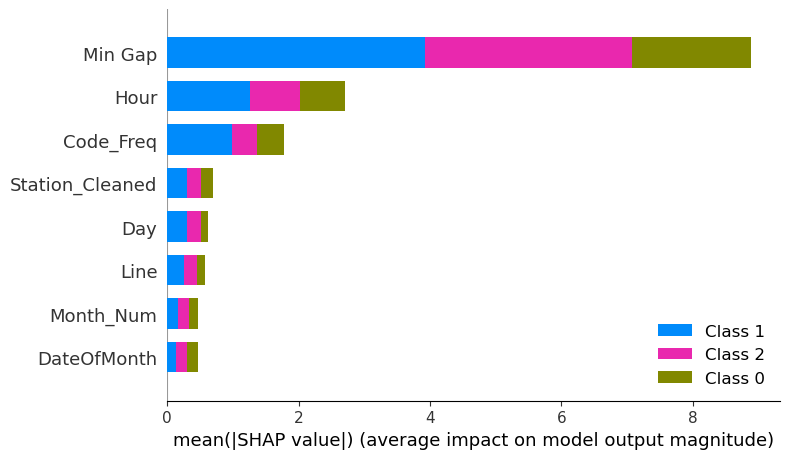

In [33]:
# Summary bar plot (global feature importance)
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names, plot_type='bar')


- Class 0: long delay(> 10 mins)
- Class 1: No Delay
- Class 2: Short Delay(< 10 mins>)

The classification report for the tuned XGBoost model shows excellent performance, achieving 98% accuracy on the test set. The model performs especially well on class 1, with a recall and F1-score of 1.00, accurately identifying nearly all instances of this dominant class. Class 2 also performs strongly, with both recall and F1-score at 0.98, indicating consistent predictions. Despite having fewer instances, class 0 maintains a solid F1-score of 0.93 and a recall of 0.92, suggesting minor misclassifications. The macro average F1-score of 0.97 reflects balanced performance across all classes, while the weighted F1-score of 0.98 highlights the model’s ability to generalize well despite class imbalance. Overall, the model demonstrates high precision and recall, making it reliable for multiclass classification tasks.

The SHAP summary plot illustrates that ‘Min Gap’ is the most impactful feature across all classes, especially for Class 1, highlighting its strong role in predicting whether a delay will occur. ‘Hour’ and ‘Code_Freq’ also contribute significantly, suggesting that time of day and historical frequency of delay types are key predictors. ‘Station_Cleaned’, ‘Day’, and ‘Line’ have moderate influence, while ‘Month_Num’ and ‘DateOfMonth’ show minimal impact, indicating that calendar-based patterns are less predictive. The color breakdown reveals how each feature contributes differently across the three classes, emphasizing the model’s reliance on operational and temporal features over seasonal ones.